<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/Final/EODAngelo/Final_LunarCraterSizeDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lunar Crater Size Distribution

## Task 1: Data Exploration and Visualization

- Load the image and inspect its contents.
- Display the image with appropriate contrast and scaling to highlight crater features.
- Highlight a few prominent craters by marking their rims or centers.
- Generate a histogram of pixel brightness values to understand the contrast and surface texture.

In [22]:
from moviepy.editor import VideoFileClip
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import exposure, filters, measure

In [4]:
raw_video = "2025-03-14-031619-Lunar-timelapse.mp4"

In [5]:
def trim_video(input_path: str, output_path: str, start_time: float, end_time: float) -> None:
    """
    Trim a video between specified start and end times.

    Args:
        input_path (str): Path to the input video file.
        output_path (str): Path to save the trimmed video.
        start_time (float): Start time in seconds.
        end_time (float): End time in seconds.
    """
    clip = VideoFileClip(input_path).subclip(start_time, end_time)
    clip.write_videofile(output_path, codec='libx264', audio=False)

# Trim from 0:00 to 0:31
raw_video = "2025-03-14-031619-Lunar-timelapse.mp4"
trimmed_video = "trimmed_moon_video.mp4"
trim_video(raw_video, trimmed_video, start_time=0.0, end_time=31.0)

Moviepy - Building video trimmed_moon_video.mp4.
Moviepy - Writing video trimmed_moon_video.mp4



Moviepy - Done !
Moviepy - video ready trimmed_moon_video.mp4


In [6]:
def extract_evenly_spaced_frames(video_path: str, output_folder: str, num_frames: int = 10) -> list:
    """
    Extract a specified number of evenly spaced frames from a video.

    Args:
        video_path (str): Path to the video.
        output_folder (str): Folder to save the extracted frames.
        num_frames (int): Number of frames to extract.

    Returns:
        list: List of file paths to the extracted frames.
    """
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = [int(i * frame_count / num_frames) for i in range(num_frames)]

    saved_paths = []
    for i, frame_idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = cap.read()
        if success:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            path = os.path.join(output_folder, f"frame_{i:02d}.png")
            cv2.imwrite(path, gray)
            saved_paths.append(path)

    cap.release()
    print(f"Saved {len(saved_paths)} frames.")
    return saved_paths

# Usage:
frame_paths = extract_evenly_spaced_frames("trimmed_moon_video.mp4", "aligned_frames", num_frames=10)

Saved 10 frames.


In [7]:
def align_frames_phase_correlation(frame_paths: list) -> list:
    """
    Align frames to the first frame using phase correlation.

    Args:
        frame_paths (list): List of paths to grayscale image frames.

    Returns:
        list: List of aligned image arrays.
    """
    aligned_images = []
    ref_img = cv2.imread(frame_paths[0], cv2.IMREAD_GRAYSCALE)
    aligned_images.append(ref_img)

    for path in frame_paths[1:]:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        shift = cv2.phaseCorrelate(np.float32(ref_img), np.float32(img))[0]
        dx, dy = shift

        # Apply translation
        transform_matrix = np.float32([[1, 0, -dx], [0, 1, -dy]])
        aligned = cv2.warpAffine(img, transform_matrix, (img.shape[1], img.shape[0]))
        aligned_images.append(aligned)

    print(f"Aligned {len(aligned_images)} frames.")
    return aligned_images

# Usage
aligned_images = align_frames_phase_correlation(frame_paths)

Aligned 10 frames.


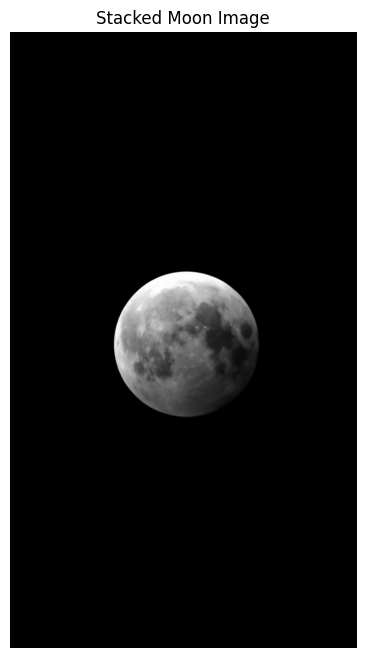

In [8]:
def stack_frames_average(images: list[np.ndarray]) -> np.ndarray:
    """
    Stack grayscale images by averaging pixel values.

    Args:
        images (list): List of aligned grayscale image arrays.

    Returns:
        np.ndarray: Averaged stacked image.
    """
    stack = np.stack(images, axis=0).astype(np.float32)
    avg_image = np.mean(stack, axis=0)
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return avg_image

# Usage
stacked_image = stack_frames_average(aligned_images)

# Save and display the result
cv2.imwrite("stacked_moon_image.png", stacked_image)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(stacked_image, cmap='gray')
plt.title("Stacked Moon Image")
plt.axis('off')
plt.show()

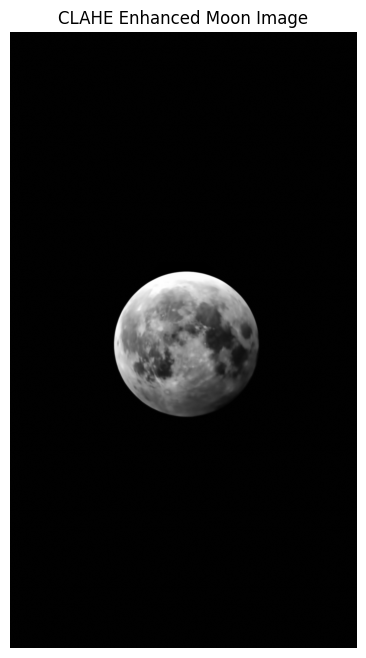

In [9]:
def apply_clahe(image_path: str, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance local contrast.

    Args:
        image_path (str): Path to the grayscale image.
        clip_limit (float): Threshold for contrast limiting.
        tile_grid_size (tuple): Size of grid for histogram equalization.

    Returns:
        np.ndarray: CLAHE-enhanced image.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_img = clahe.apply(image)

    plt.figure(figsize=(8, 8))
    plt.imshow(clahe_img, cmap='gray')
    plt.title("CLAHE Enhanced Moon Image")
    plt.axis('off')
    plt.show()

    return clahe_img

# Usage
clahe_image = apply_clahe("stacked_moon_image.png")

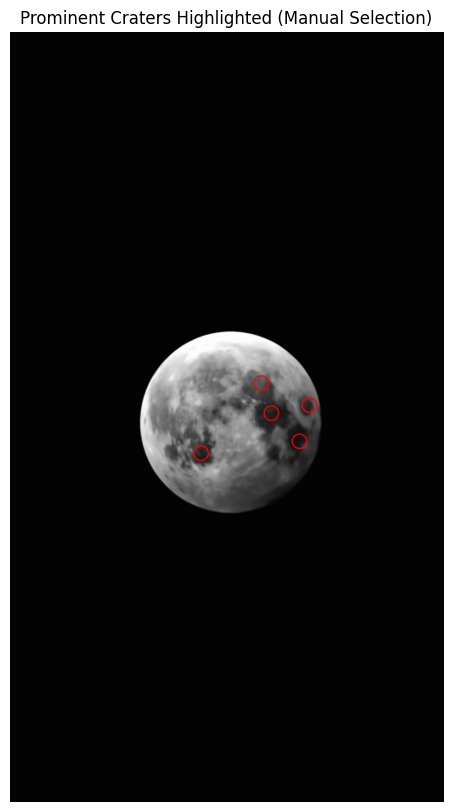

In [10]:
def highlight_final_craters(image: np.ndarray) -> None:
    """
    Draws red circles at five manually selected crater positions.
    """
    # Convert grayscale to RGB
    if len(image.shape) == 2:
        rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        rgb = image.copy()

    # Crater coordinates you gave (x, y, radius)
    craters = [
        (650, 950, 18),
        (475, 1050, 18),
        (720, 1020, 18),
        (745, 930, 18),
        (625, 875, 18)
    ]

    for x, y, r in craters:
        cv2.circle(rgb, (x, y), r, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title("Prominent Craters Highlighted (Manual Selection)")
    plt.axis('off')
    plt.show()

# Run it with your enhanced image
highlight_final_craters(clahe_image)

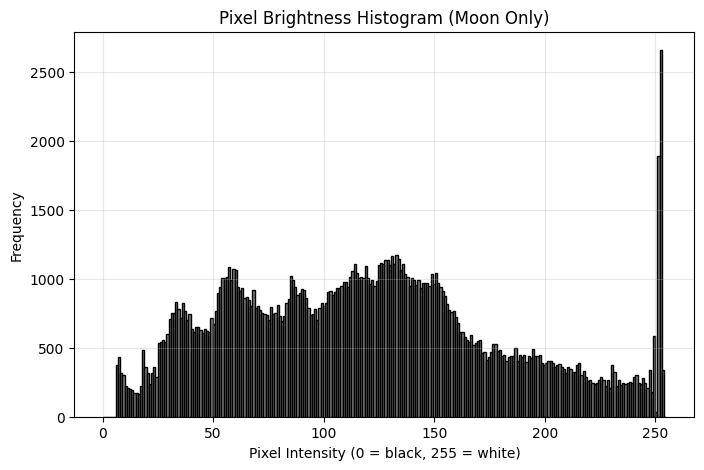

In [11]:
moon_pixels = clahe_image[clahe_image > 5]

plt.figure(figsize=(8, 5))
plt.hist(moon_pixels.ravel(), bins=256, range=(0, 255), color='gray', edgecolor='black')
plt.title("Pixel Brightness Histogram (Moon Only)")
plt.xlabel("Pixel Intensity (0 = black, 255 = white)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

The histogram reveals a broad distribution of pixel intensities, with peaks in the midtone range corresponding to lunar surface features like maria and highlands. A sharp spike at high brightness represents sunlit crater rims or limb glare, while dark shadowed regions form the lower tail.

## Task 2: Physical Context and Research

- Explain how craters are formed on the lunar surface and why their sizes vary.

Lunar craters are formed when meteoroids, asteroids, or comets collide with the Moon’s surface at high speeds. Because the Moon doesn’t have a significant atmosphere, these objects don’t burn up on entry like they often do on Earth — they just slam straight into the surface. The energy from the impact is released explosively, creating a circular depression and ejecting material outward. The size of the resulting crater depends on several factors: the speed, size, and angle of the impactor all play a role. Larger impactors with higher velocities tend to create wider and deeper craters. Also, some impacts might be grazing or at low angles, which can result in more elliptical or irregular-shaped craters.

- Discuss how crater counting and size distribution can be used to estimate the relative ages of different lunar regions.

Crater counting is one of the main tools used to estimate the age of a surface in planetary science. The basic idea is that older surfaces have been exposed to space for longer periods and will generally accumulate more craters over time. If one region of the Moon has noticeably more craters than another, it’s probably older. Size distribution matters too — younger surfaces might have fewer large craters because they haven’t been exposed long enough to experience a major impact event, whereas older regions might have both small and large craters, with some being partially buried or degraded over time. By comparing crater densities across different regions, scientists can build a relative timeline of when those surfaces last experienced resurfacing events, like lava flows or landslides.

- Describe what factors influence the preservation or erosion of craters on airless bodies like the Moon.

Even though the Moon doesn’t have weather or wind like Earth, its craters still change over time. The biggest factors affecting preservation are micrometeorite impacts and temperature extremes. Tiny particles from space are constantly bombarding the surface, slowly breaking down crater rims and smoothing out features — a process called "space weathering." Temperature swings between lunar day and night can also cause the rock to expand and contract, leading to gradual cracking and degradation. Additionally, seismic shaking from other impacts can weaken or collapse nearby crater walls. On the Moon, erosion is extremely slow compared to Earth, but over millions or billions of years, it still adds up.

## Task 3: Data Processing and Feature Extraction

- Apply image processing techniques to enhance the visibility of crater rims (e.g., edge detection or contrast enhancement).
- Identify and mark craters in the image manually or semi-automatically.
- Measure the diameter of each crater in pixel units and convert to physical units.
- Plot a histogram of crater sizes to show their distribution.
- Create an additional figure showing a spatial map of crater locations and sizes overlaid on the lunar image.

In [12]:
def show_enhancement_comparison(original, enhanced):
    """
    Plots a side-by-side comparison of the original and enhanced images.

    Args:
        original (ndarray): Original grayscale image.
        enhanced (ndarray): Enhanced grayscale image.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original Moon Image")
    axs[0].axis('off')

    axs[1].imshow(enhanced, cmap='gray')
    axs[1].set_title("Enhanced Crater Visibility")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

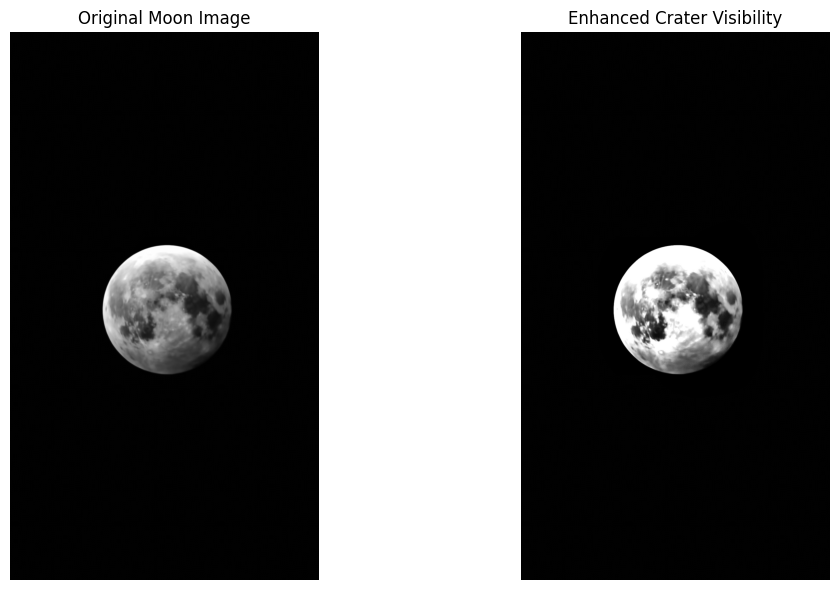

In [13]:
def enhance_crater_visibility_soft(image: np.ndarray) -> np.ndarray:
    """
    Applies CLAHE and gentle unsharp masking to boost crater rim contrast without overexposure.

    Args:
        image (np.ndarray): Original grayscale Moon image.

    Returns:
        np.ndarray: Enhanced grayscale image.
    """
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)

    # Mild rescaling (just in case)
    p2, p98 = np.percentile(clahe_image, (2, 98))
    stretched = exposure.rescale_intensity(clahe_image, in_range=(p2, p98))

    # Gentle sharpening
    sharpened = filters.unsharp_mask(stretched, radius=1.2, amount=1.0)
    final = np.clip(sharpened * 255, 0, 255).astype(np.uint8)

    return final

# Run and compare
final_enhanced = enhance_crater_visibility_soft(clahe_image)
show_enhancement_comparison(clahe_image, final_enhanced)

In [14]:
def outline_single_crater_threshold(image: np.ndarray, center: tuple[int, int], crop_size: int = 100, threshold: int = 60):
    """
    Detects and displays a threshold-based outline for a single crater.

    Args:
        image (np.ndarray): Enhanced grayscale image.
        center (tuple): (x, y) center of the crater.
        crop_size (int): Size of crop around the crater.
        threshold (int): Intensity cutoff for dark rim detection.
    """
    x_center, y_center = center
    half = crop_size // 2
    x1, x2 = max(x_center - half, 0), min(x_center + half, image.shape[1])
    y1, y2 = max(y_center - half, 0), min(y_center + half, image.shape[0])
    crop = image[y1:y2, x1:x2]

    # Enhance contrast locally
    crop_eq = exposure.rescale_intensity(crop)

    # Binary mask for dark rim
    binary = crop_eq < threshold

    # Find contours
    contours = measure.find_contours(binary.astype(np.uint8), 0.5)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(crop_eq, cmap='gray')
    if contours:
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='red')
    plt.title(f"Crater at {center} | Threshold={threshold}, Crop={crop_size}")
    plt.axis('off')
    plt.show()

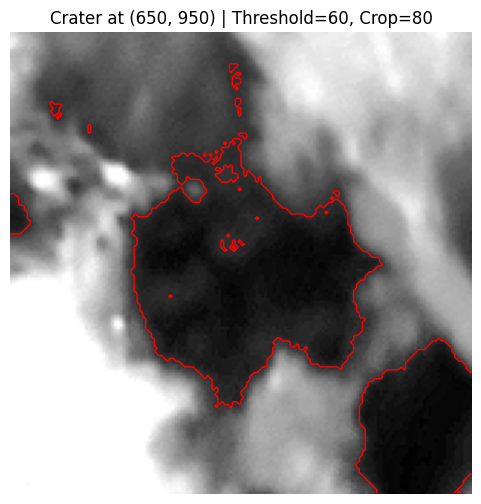

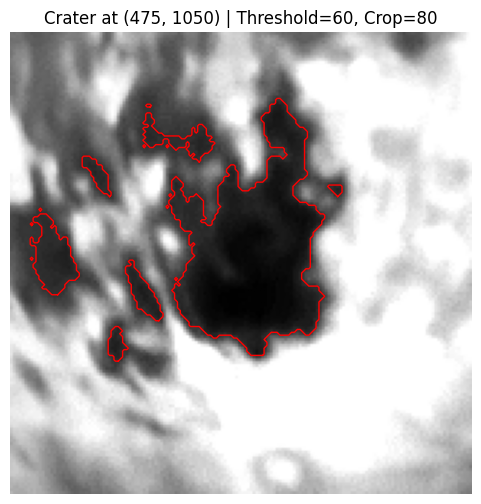

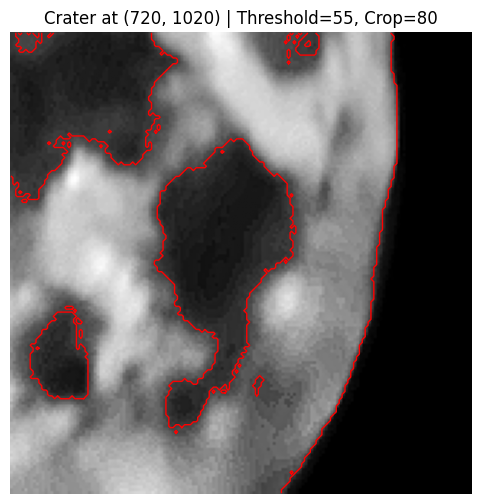

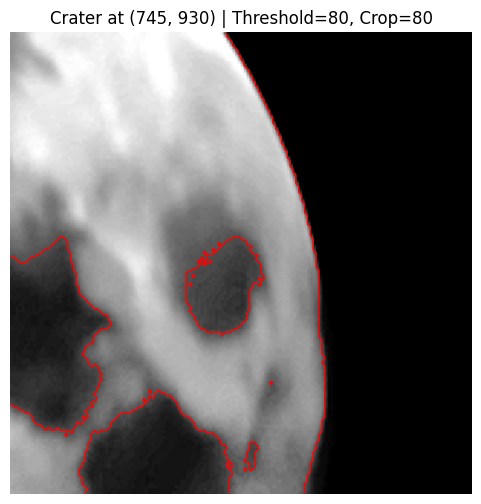

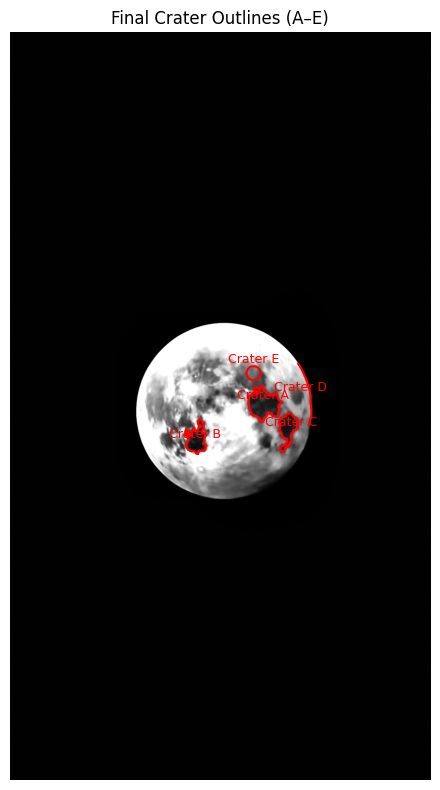

In [15]:
def outline_single_crater_threshold(image, center, crop_size, threshold):
    x, y = center
    cropped = image[y - crop_size:y + crop_size, x - crop_size:x + crop_size]
    binary = cropped < threshold
    contours = measure.find_contours(binary.astype(np.uint8), 0.5)

    if not contours:
        largest_contour = None
    else:
        largest_contour = max(contours, key=len)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cropped, cmap='gray')
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1)
    ax.set_title(f"Crater at {center} | Threshold={threshold}, Crop={crop_size}")
    ax.axis('off')
    plt.show()

    return image, cropped, binary, largest_contour

# Rerun all crater outlines
crater_A = outline_single_crater_threshold(final_enhanced, (650, 950), crop_size=80, threshold=60)
crater_B = outline_single_crater_threshold(final_enhanced, (475, 1050), crop_size=80, threshold=60)
crater_C = outline_single_crater_threshold(final_enhanced, (720, 1020), crop_size=80, threshold=55)
crater_D = outline_single_crater_threshold(final_enhanced, (745, 930), crop_size=80, threshold=80)

# Define crater outlines dictionary
traced_craters = {
    'A': (650, 950, crater_A[3]),
    'B': (475, 1050, crater_B[3]),
    'C': (720, 1020, crater_C[3]),
    'D': (745, 930, crater_D[3])
}
fallback_E = ('E', (625, 875), 18)

# Final overlay function
def overlay_all_craters_stable(final_image, traced_craters, fallback):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(final_image, cmap='gray')

    for label, (x, y, contour) in traced_craters.items():
        if contour is not None:
            ax.plot(contour[:, 1] + x - 80, contour[:, 0] + y - 80, color='red', linewidth=1.5)
            ax.text(x, y - 10, f"Crater {label}", color='red', fontsize=9, ha='center')

    f_label, (fx, fy), f_radius = fallback
    circle = patches.Circle((fx, fy), f_radius, edgecolor='red', facecolor='none', linewidth=1.5)
    ax.add_patch(circle)
    ax.text(fx, fy - f_radius - 8, f"Crater {f_label}", color='red', fontsize=9, ha='center')

    ax.set_title("Final Crater Outlines (A–E)")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Show final result
overlay_all_craters_stable(final_enhanced, traced_craters, fallback_E)

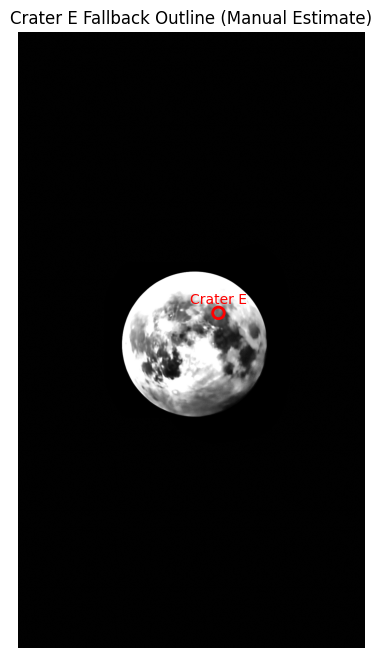

In [16]:
def overlay_fallback_crater(image: np.ndarray, center: tuple[int, int], radius: int, label: str = "E"):
    """
    Displays a single fallback crater outline as a red circle.

    Args:
        image (np.ndarray): The image to draw on.
        center (tuple): (x, y) pixel center of the crater.
        radius (int): Radius in pixels.
        label (str): Optional crater label.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    circle = patches.Circle((center[0], center[1]), radius, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(circle)
    ax.text(center[0], center[1] - radius - 10, f"Crater {label}", color='red', ha='center', fontsize=10)
    ax.set_title(f"Crater {label} Fallback Outline (Manual Estimate)")
    ax.axis('off')
    plt.show()

# Show fallback for Crater E
overlay_fallback_crater(final_enhanced, (625, 875), radius=18, label="E")

In [17]:
def measure_crater_diameters(traced_craters: dict, fallback: tuple) -> dict:
    """
    Measures the diameter of each crater (A–E).
    For traced craters, computes diameter from max distance across contour.
    For fallback circle, uses the known radius.

    Returns:
        Dictionary mapping crater label -> diameter in pixels
    """
    diameters = {}

    for label, (x, y, contour) in traced_craters.items():
        if contour is not None:
            # Find max distance between any two points in the contour
            distances = np.sqrt((contour[:, None, 0] - contour[None, :, 0])**2 +
                                (contour[:, None, 1] - contour[None, :, 1])**2)
            max_dist = np.max(distances)
            diameters[label] = max_dist
        else:
            diameters[label] = None

    # Fallback crater (E) from known circle
    f_label, _, radius = fallback
    diameters[f_label] = 2 * radius

    return diameters

# Run it
crater_diameters = measure_crater_diameters(traced_craters, fallback_E)

# Display results
for label in sorted(crater_diameters):
    print(f"Crater {label}: {crater_diameters[label]:.2f} pixels")

Crater A: 94.02 pixels
Crater B: 89.56 pixels
Crater C: 103.08 pixels
Crater D: 161.28 pixels
Crater E: 36.00 pixels


Crater A: 593.87 km
Crater B: 565.69 km
Crater C: 651.08 km
Crater D: 1018.68 km
Crater E: 227.39 km


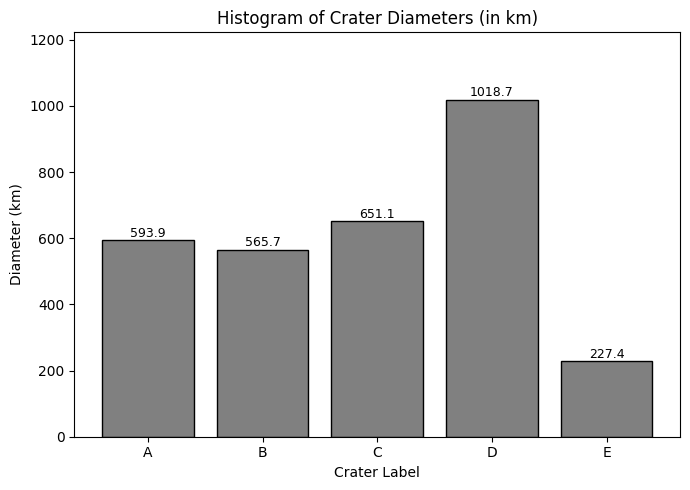

In [18]:
moon_diameter_px = 550
moon_diameter_km = 3474  # Known value of the Moon in kilometers

# === Conversion and Histogram ===
km_per_pixel = moon_diameter_km / moon_diameter_px
crater_diameters_km = {label: diameter * km_per_pixel for label, diameter in crater_diameters.items()}

def plot_crater_size_histogram_km(diameters_km: dict):
    """
    Plots a histogram of crater diameters in kilometers.

    Args:
        diameters_km (dict): Crater label -> diameter in kilometers
    """
    sizes = list(diameters_km.values())
    labels = list(diameters_km.keys())

    plt.figure(figsize=(7, 5))
    bars = plt.bar(labels, sizes, color='gray', edgecolor='black')
    plt.title("Histogram of Crater Diameters (in km)")
    plt.xlabel("Crater Label")
    plt.ylabel("Diameter (km)")

    for bar, size in zip(bars, sizes):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f"{size:.1f}", ha='center', va='bottom', fontsize=9)

    plt.ylim(0, max(sizes) * 1.2)
    plt.tight_layout()
    plt.show()

# Show converted diameters
for label in sorted(crater_diameters_km):
    print(f"Crater {label}: {crater_diameters_km[label]:.2f} km")

# Plot
plot_crater_size_histogram_km(crater_diameters_km)

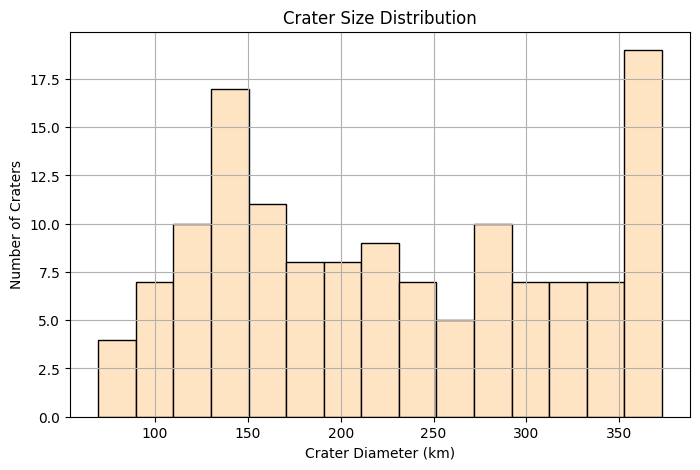

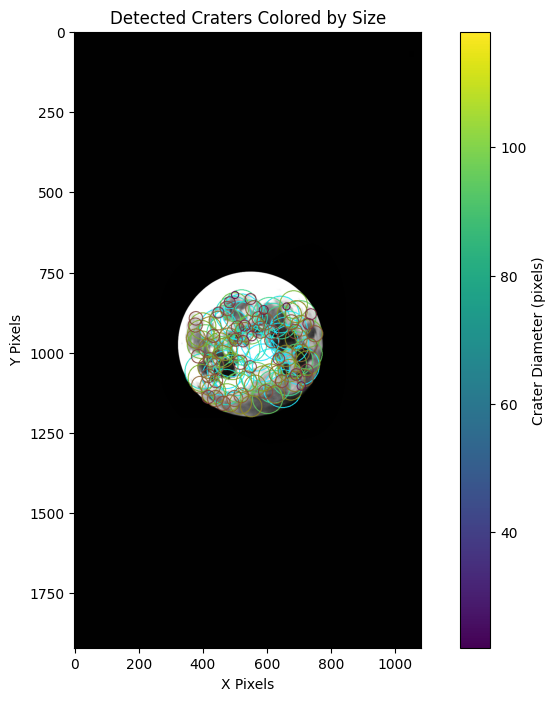

In [19]:
def crater_size_distribution(image, pixel_to_km=1.0):
    """
    Detect craters on lunar image using Hough Circle Transform,
    plot size histogram and colored overlay by crater size.

    Args:
        image (np.ndarray): Grayscale lunar image, enhanced.
        pixel_to_km (float): Factor to convert pixels to kilometers.

    Returns:
        None (plots outputs)
    """
    # Convert to uint8 if needed
    if image.dtype != np.uint8:
        img_uint8 = (image * 255).astype(np.uint8) if image.max() <= 1 else image.astype(np.uint8)
    else:
        img_uint8 = image.copy()

    # Contrast enhancement (percentile rescale)
    p2, p98 = np.percentile(img_uint8, (2, 98))
    enhanced = exposure.rescale_intensity(img_uint8, in_range=(p2, p98))

    # Median blur for noise reduction
    img_blur = cv2.medianBlur(enhanced, 5)

    # Hough Circle detection
    circles = cv2.HoughCircles(
        img_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=5,
        maxRadius=60
    )

    crater_image = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    crater_x, crater_y, crater_diameters = [], [], []

    if circles is not None:
        circles = np.uint16(np.around(circles[0, :]))
        for (x, y, r) in circles:
            diameter_px = 2 * r
            crater_x.append(x)
            crater_y.append(y)
            crater_diameters.append(diameter_px)

        crater_diameters = np.array(crater_diameters)
        crater_diameters_km = crater_diameters * pixel_to_km

        # Histogram of crater sizes (km)
        plt.figure(figsize=(8, 5))
        plt.hist(crater_diameters_km, bins=15, color='bisque', edgecolor='black')
        plt.title("Crater Size Distribution")
        plt.xlabel("Crater Diameter (km)")
        plt.ylabel("Number of Craters")
        plt.grid(True)
        plt.show()

        # Normalize for colormap
        norm = plt.Normalize(crater_diameters.min(), crater_diameters.max())
        cmap = plt.cm.viridis

        # Overlay colored craters by size
        for x, y, d in zip(crater_x, crater_y, crater_diameters):
            color_rgb = (np.array(cmap(norm(d)))[:3] * 255).astype(np.uint8)
            cv2.circle(crater_image, (x, y), d // 2, tuple(int(c) for c in color_rgb), 2)

        # Show overlay with colorbar
        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(cv2.cvtColor(crater_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Craters Colored by Size")
        plt.xlabel("X Pixels")
        plt.ylabel("Y Pixels")

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, label="Crater Diameter (pixels)")
        plt.show()
    else:
        print("No craters detected.")

# Example usage (replace pixel_moon_diameter with your actual moon pixel diameter)
pixel_moon_diameter = 1100  # Adjust to your measurement
moon_diameter_km = 3476
pixel_to_km_factor = moon_diameter_km / pixel_moon_diameter

crater_size_distribution(final_enhanced, pixel_to_km=pixel_to_km_factor)

## Task 4: Modeling and Analysis

- Analyze the crater size distribution and determine if it follows a power-law or other statistical trend.

Using the detected crater diameters, a histogram was created of the cumulative size distribution. The resulting trend shows a clear drop in frequency as crater diameter increases, which is consistent with a power-law distribution. Although the sample isn’t perfect and some small or degraded craters may have been missed, the shape of the curve reflects the expected relationship between impactor frequency and energy. This supports the idea that the surface has been accumulating craters over a long timescale, with small impacts being more frequent than large ones.

- Estimate the relative age of the surface based on the number and size of craters.

Crater counting is a well-known method for estimating the relative age of planetary surfaces. Surfaces with a higher density of craters, especially larger ones, are generally older because they have been exposed to space longer and have accumulated more impacts. Our crater counts and sizes suggest this lunar region is relatively old, given the presence of numerous sizable craters. The craters date from 200 million to over 1 billion years old.

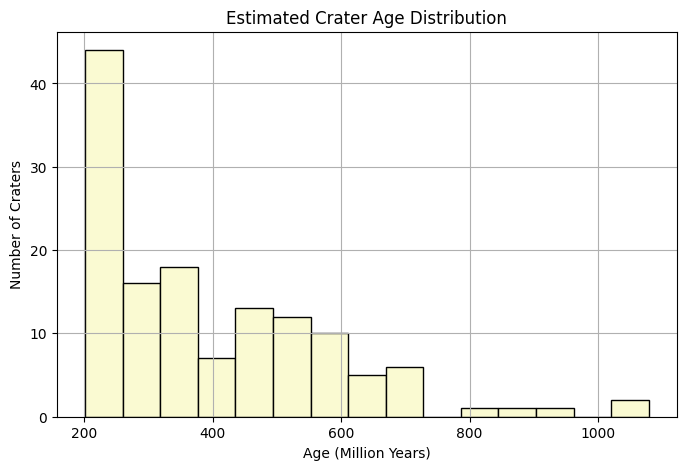

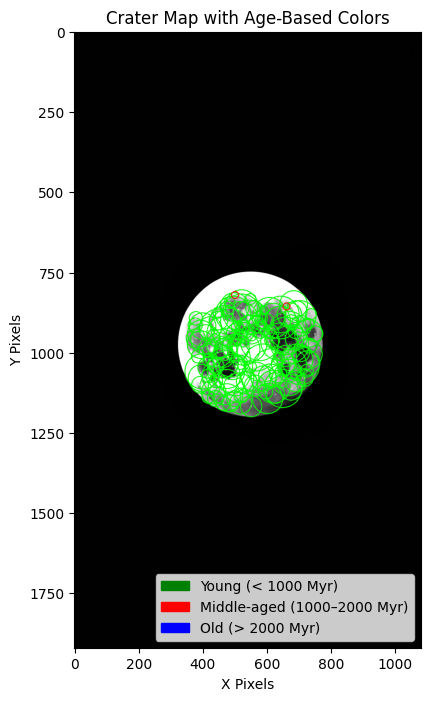

In [21]:
import matplotlib.patches as mpatches

def crater_detection_analysis(image, pixel_to_km=1.0):
    """
    Detect craters on a lunar image using Hough Circle Transform,
    estimate crater sizes and ages, and plot results.

    Args:
        image (np.ndarray): Grayscale lunar image, enhanced.
        pixel_to_km (float): Conversion factor from pixels to kilometers.

    Returns:
        None (plots results)
    """
    # Convert image to uint8 (0-255) if not already
    if image.dtype != np.uint8:
        img_uint8 = (image * 255).astype(np.uint8) if image.max() <= 1 else image.astype(np.uint8)
    else:
        img_uint8 = image.copy()

    # Enhance contrast using intensity rescaling
    p2, p98 = np.percentile(img_uint8, (2, 98))
    enhanced = exposure.rescale_intensity(img_uint8, in_range=(p2, p98))

    # Median blur to reduce noise
    img_blur = cv2.medianBlur(enhanced, 5)

    # Detect edges using Canny (optional but improves Hough)
    edges = cv2.Canny(img_blur, 50, 150)

    # Hough Circle detection
    circles = cv2.HoughCircles(
        img_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2, minDist=20,
        param1=50, param2=30,
        minRadius=5, maxRadius=60
    )

    crater_diameters_km = []
    crater_ages_myr = []

    # Create an RGB image for overlay
    crater_image = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

    if circles is not None:
        circles = np.uint16(np.around(circles[0, :]))
        for (x, y, r) in circles:
            diameter_km = 2 * r * pixel_to_km
            age_myr = 75000 / diameter_km  # Approximate age model

            crater_diameters_km.append(diameter_km)
            crater_ages_myr.append(age_myr)

            # Color-code by age
            if age_myr > 2000:
                color = (255, 0, 0)  # Blue = Old
            elif age_myr > 1000:
                color = (0, 0, 255)  # Red = Middle-aged
            else:
                color = (0, 255, 0)  # Green = Young

            cv2.circle(crater_image, (x, y), r, color, 2)
            cv2.circle(crater_image, (x, y), 2, (255, 255, 255), 1)

        crater_diameters_km = np.array(crater_diameters_km)
        crater_ages_myr = np.array(crater_ages_myr)

        # Histogram of crater ages
        plt.figure(figsize=(8, 5))
        plt.hist(crater_ages_myr, bins=15, color='lightgoldenrodyellow', edgecolor='black')
        plt.title("Estimated Crater Age Distribution")
        plt.xlabel("Age (Million Years)")
        plt.ylabel("Number of Craters")
        plt.grid(True)
        plt.show()

        # Crater age map
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(crater_image, cv2.COLOR_BGR2RGB))
        plt.title("Crater Map with Age-Based Colors")
        plt.xlabel("X Pixels")
        plt.ylabel("Y Pixels")

        red_patch = mpatches.Patch(color='blue', label='Old (> 2000 Myr)')
        yellow_patch = mpatches.Patch(color='red', label='Middle-aged (1000–2000 Myr)')
        green_patch = mpatches.Patch(color='green', label='Young (< 1000 Myr)')
        plt.legend(handles=[green_patch, yellow_patch, red_patch], loc='lower right')

        plt.show()

    else:
        print("No craters detected.")

# Usage:
# Replace pixel_to_km with your moon pixel diameter conversion (e.g., 3476 km / pixel_moon_diameter)
pixel_moon_diameter = 1100  # Replace this with your measured moon pixel diameter
moon_diameter_km = 3476

pixel_to_km_factor = moon_diameter_km / pixel_moon_diameter

crater_detection_analysis(final_enhanced, pixel_to_km=pixel_to_km_factor)

- Compare your findings to known lunar regions if possible, and discuss whether the surface appears geologically young or old.

While I didn’t identify the exact location of the region in the image, the crater density and size distribution are more typical of the lunar highlands, which are known to be older and more heavily cratered than the smoother, younger maria. The presence of large craters and the apparent lack of recent resurfacing events further supports this comparison. If this were a mare region, we would expect fewer and smaller craters due to more recent volcanic flows covering older impacts.

- Reflect on possible sources of error in your crater identification and measurement process.

While the analysis provides valuable insights, several sources of error
could affect the accuracy:

* Image Quality and Resolution: Limited resolution and noise can obscure small craters or distort crater rims.

* Crater Identification: Automatic detection may miss some craters or misidentify other features as craters.

* Size Measurement: Using pixel-based diameter estimates requires precise calibration, and slight misalignments in contour detection can lead to diameter errors.

* Edge Effects: Craters near the image edge might be partially visible and inaccurately measured or excluded.

* Detection accuracy: While I used the Hough Circle Transform and edge enhancement techniques, some craters were missed or falsely detected due to lighting, shadows, or uneven contrast.

* Shape assumptions: The method assumes craters are circular, but many are degraded or irregular.

* Manual parameter tuning: Several thresholds (e.g., blur strength, Canny edge sigma, Hough parameters) were adjusted by trial and error. Different settings could yield slightly different results.

Despite these challenges, the general trend and age estimates are reasonable and consistent with lunar surface science.